In this notebook a quantum system is used to store, represent and manipulate the information contained within a grayscale image.

The image we use is taken from the MNIST dataset, downscaled to a 8x8 pixel resolution.

We map the grayscale intensity of each pixel to a rotation angle for a quantum gate applied to a corresponding qubit in a quantum circuit. Specifically, we employ a rotation around the Y axis (Ry gate), where a grayscale intensity of 0 corresponds to no rotation (qubit remains in the |0⟩ state), and a grayscale intensity of 255 corresponds to a π rotation (qubit is rotated to the |1⟩ state). Intermediate grayscale values result in corresponding intermediate rotation angles.

We then execute this quantum circuit on a quantum simulator and perform a measurement on each qubit. This results in a binary string outcome (a quantum state) for each execution of the circuit, with the probability of each outcome governed by the quantum mechanical principle of superposition.

The output is collected in the form of a histogram over these quantum states, represented as a dictionary with binary strings as keys. Each binary string represents a simultaneous measurement result of all qubits, in reverse order, i.e., the first qubit is the rightmost bit in the string.

For each qubit, we compute the probability of it being measured in the |1⟩ state by summing the counts of all outcomes where this qubit was measured as |1⟩. This probability is then used to determine the grayscale intensity of the corresponding pixel in the reconstructed image.

This notebook provides an intuitive quantum analogy to classical image representation, where the grayscale intensity of image pixels corresponds to the probability of a qubit being in the |1⟩ state. It's a clear example of a quantum algorithm where the processing capability of a quantum system is used to manipulate and store information.

In [1]:
#! pip install qiskit qiskit_aer medmnist

In [2]:
from keras.datasets import mnist
from medmnist import ChestMNIST
from skimage.transform import resize
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np

In [3]:
# Load ChestMNIST dataset
dataset = ChestMNIST(split='train', download=True)

# Take one image from the dataset and convert it to np array
image = np.array(dataset[0][0])

In [4]:
# This image is to large to encode into a quantum circuit. Let's downscale it
new_size = (5, 5)
qc_size = new_size[0] * new_size[1]

# Downscale it to new_size
small_image = resize(image, new_size, mode='reflect', anti_aliasing=True)

# Normalize pixel values to the range [0, 1]
small_image = small_image / 25.0

In [5]:
# Create quantum circuit with 16 qubits
qc = QuantumCircuit(qc_size, qc_size)  # Added 16 classical bits for measurement

# Encode the grayscale values of the pixels into the amplitudes of the quantum states
for i in range(qc_size):
    if small_image.flatten()[i] > 0:
        qc.ry(2*np.arcsin(np.sqrt(small_image.flatten()[i])), i)

# Measure the qubits
for i in range(qc_size):
    qc.measure(i, i)

In [6]:
# Transpile the circuit for the QASM simulator
simulator = AerSimulator(method='statevector') # Use 'statevector' method for larger circuits
qc = transpile(qc, simulator)

# Run the circuit
shots = 1000
result = simulator.run(qc, shots=shots).result()

# Get the counts of the quantum states
counts = result.get_counts(qc)

In [7]:
# Prepare an array to store the counts for each qubit
qubit_counts = np.zeros(qc_size)

# Loop through all the results
for key, value in counts.items():
    # For each result, add the counts to the corresponding qubit
    for i in range(qc_size):
        # Note the [::-1] to reverse the string to correct Qiskit's convention
        if key[::-1][i] == '1':
            qubit_counts[i] += value

# Normalize the qubit counts to get the pixel values
decoded_image = qubit_counts / shots

# Reshape the decoded image to new_size
decoded_image = decoded_image.reshape(new_size)

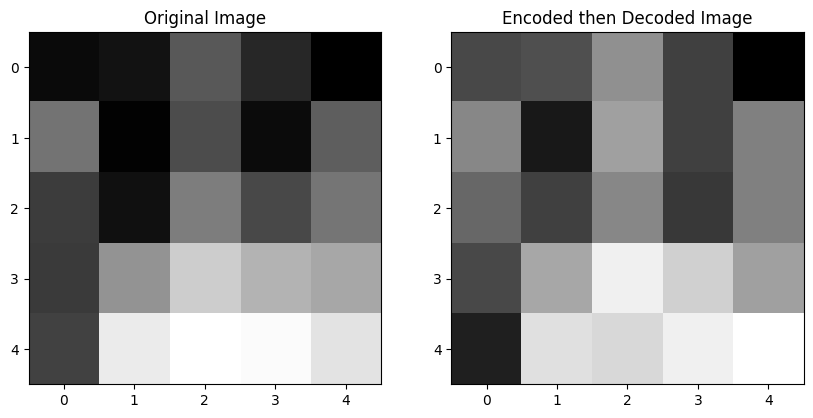

In [8]:
# Create a subplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax[0].imshow(small_image, cmap='gray')
ax[0].set_title('Original Image')

# Display the decoded image
ax[1].imshow(decoded_image, cmap='gray')
ax[1].set_title('Encoded then Decoded Image')

plt.show()